## 6.1 从全连接层到卷积

### 练习

1. 假设卷积层(6.1.3)覆盖的局部区域delta = 0。在这种情况下，证明卷积内核为每组通道独立地实现一个全连接层。

pass

2. 为什么平移不变性可能也不是好主意呢？

pass

3. 当从图像边界像素获取隐藏表示时，我们需要思考哪些问题？

(1). 卷积填充问题：
- 零填充（Zero Padding）：在卷积操作中，如果卷积核不能完全覆盖边缘像素区域，那么该区域可能会被忽略，导致输出表示变小。通过添加零填充可以让卷积核覆盖边缘像素。
- 镜像填充（Mirror Padding）：对于边缘像素，可以通过镜像反转的方式填充边缘，以保持边缘信息的完整性。

(2).特征表示尺寸缩小：在多次卷积和池化操作之后，特征图会变得越来越小，最终可能导致边缘信息被丢弃或失真。可以考虑减少池化层的数量或使用合适的填充策略，以保留边缘像素的信息。

(3).边缘特征的偏差：由于边缘像素缺乏周围的上下文信息，隐藏表示可能会出现偏差。使用较大的卷积核或全局上下文来减少这个问题，如使用全局池化或自注意力机制。

(4).池化操作：在池化层中，由于卷积核对边界像素的覆盖可能不完整，导致池化操作在边缘像素上产生不准确的结果。可以使用填充策略来确保池化核覆盖边缘像素。

(5).数据增强的边界效应：数据增强（如旋转、裁剪、镜像）可能引入新的边缘区域，需要额外的填充来确保模型能够处理这些新出现的边界像素。

(6).分辨率和图像尺寸：小分辨率或低质量的图像在边缘像素上可能有失真，需要高质量的原始数据才能保证有效的隐藏表示。

(7).边界情况的特殊处理：在某些任务（如图像分割、物体检测）中，可能需要对边缘区域的像素进行特别标注或处理，以确保模型准确识别图像中的边界对象。

4. 描述一个类似的音频卷积层的架构。

输入数据是一维或者二维的。输入数据是音频信号或者频谱图，也就是时间-频率图。其他方式和传统的CNN类似

5. 卷积层也适合于文本数据吗？为什么？

适合。

1. 局部特征提取：

在文本处理中，卷积核可以用于捕获单词之间的局部模式。例如，在情感分析或分类任务中，词组和短语之间的局部关系往往能提供有价值的信息。

2. 多尺寸卷积核：

使用不同尺寸的卷积核可以捕获不同长度的语法结构。例如，尺寸较小的卷积核可以捕获短语或双词关系，而较大的卷积核可以捕获更长的依赖关系。

3. 位置不变性：

卷积操作具有位置不变性，可以识别文本中同样的模式而不受位置的影响。这在任务如文本分类中很有用，因为情感或主题通常在句子的不同位置都可以出现。

4. 快速计算和共享权重：

卷积层共享权重，并行计算能力强。这使得它比循环神经网络（RNN）更快，适合处理长文本数据，特别是对于单词嵌入表示的文本。

5. 多通道文本表示：

使用多个通道的词嵌入表示（如静态词嵌入、动态词嵌入、字符嵌入等），卷积层可以组合和融合这些特征，从而为下游任务提供更丰富的输入。

6. 证明在6.1.6中 f * g == g * f

pass

## 6.2 图像卷积

### 6.2.1 互相关运算

In [1]:
import torch
import torch.nn as nn
from d2l import torch as d2l

In [2]:
# X和K的相关性运算

def corr2d(X, K): #@save
  h, w = K.shape
  Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
  for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
      Y[i, j] = (X[i: i + h, j: j + w] * K).sum()
  return Y

In [3]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

In [4]:
# 2维卷积层
class Conv2D(nn.Module):
  def __init__(self, kernel_size):
    super().__init__()
    self.weight = nn.Parameter(torch.rand(kernel_size))
    self.bias = nn.Parameter(torch.zeros(1))
    
  def forward(self, x):
    return corr2d(x, self.weight) + self.bias

### 6.2.3 图像中目标的边缘检测

In [5]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [6]:
K = torch.tensor([[1.0, -1.0]])

In [7]:
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [8]:
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

### 6.2.4 学习卷积核

In [9]:
# 构造一个二维卷积层，它具有1个输出通道和形状为（1，2）的卷积核
conv2d = nn.Conv2d(1, 1, kernel_size=(1, 2), bias=False)

# 批量大小、通道、高度、宽度
# 其中批量大小和通道数都为1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))

lr = 3e-2

# 学习卷积核
for i in range(100):
  Y_hat = conv2d(X)
  l = (Y_hat - Y) ** 2
  conv2d.zero_grad()
  l.sum().backward()
  conv2d.weight.data[:] -= lr * conv2d.weight.grad
  if (i + 1) % 2 == 0:
    print(f'epoch {i + 1}, loss = {l.sum():.3f}')

epoch 2, loss = 3.371
epoch 4, loss = 0.580
epoch 6, loss = 0.103
epoch 8, loss = 0.020
epoch 10, loss = 0.004
epoch 12, loss = 0.001
epoch 14, loss = 0.000
epoch 16, loss = 0.000
epoch 18, loss = 0.000
epoch 20, loss = 0.000
epoch 22, loss = 0.000
epoch 24, loss = 0.000
epoch 26, loss = 0.000
epoch 28, loss = 0.000
epoch 30, loss = 0.000
epoch 32, loss = 0.000
epoch 34, loss = 0.000
epoch 36, loss = 0.000
epoch 38, loss = 0.000
epoch 40, loss = 0.000
epoch 42, loss = 0.000
epoch 44, loss = 0.000
epoch 46, loss = 0.000
epoch 48, loss = 0.000
epoch 50, loss = 0.000
epoch 52, loss = 0.000
epoch 54, loss = 0.000
epoch 56, loss = 0.000
epoch 58, loss = 0.000
epoch 60, loss = 0.000
epoch 62, loss = 0.000
epoch 64, loss = 0.000
epoch 66, loss = 0.000
epoch 68, loss = 0.000
epoch 70, loss = 0.000
epoch 72, loss = 0.000
epoch 74, loss = 0.000
epoch 76, loss = 0.000
epoch 78, loss = 0.000
epoch 80, loss = 0.000
epoch 82, loss = 0.000
epoch 84, loss = 0.000
epoch 86, loss = 0.000
epoch 88, loss 

In [10]:
conv2d.weight.data.reshape((1, 2))

tensor([[ 1.0000, -1.0000]])

### 练习

1. 构建一个具有对角线边缘的图像X。
  - 如果将本节中举例的卷积核K应用于X，会发生什么情况？
  - 如果转置X会发生什么？
  - 如果转置K会发生什么？

In [16]:
X = torch.eye(6)
X, K

(tensor([[1., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 1.]]),
 tensor([[ 1., -1.]]))

In [17]:
# 如果将本节中举例的卷积核K应用于X，会发生什么情况？
print(corr2d(X, K))

# 如果转置X会发生什么？
# 和不转置相同
print(corr2d(X.T, K))

# 如果转置K会发生什么？
print(corr2d(X, K.T))

tensor([[ 1.,  0.,  0.,  0.,  0.],
        [-1.,  1.,  0.,  0.,  0.],
        [ 0., -1.,  1.,  0.,  0.],
        [ 0.,  0., -1.,  1.,  0.],
        [ 0.,  0.,  0., -1.,  1.],
        [ 0.,  0.,  0.,  0., -1.]])
tensor([[ 1.,  0.,  0.,  0.,  0.],
        [-1.,  1.,  0.,  0.,  0.],
        [ 0., -1.,  1.,  0.,  0.],
        [ 0.,  0., -1.,  1.,  0.],
        [ 0.,  0.,  0., -1.,  1.],
        [ 0.,  0.,  0.,  0., -1.]])
tensor([[ 1., -1.,  0.,  0.,  0.,  0.],
        [ 0.,  1., -1.,  0.,  0.,  0.],
        [ 0.,  0.,  1., -1.,  0.,  0.],
        [ 0.,  0.,  0.,  1., -1.,  0.],
        [ 0.,  0.,  0.,  0.,  1., -1.]])


2. 在我们创建的Conv2D自动求导时，有什么错误消息？

没发现什么错误消息。

In [23]:
Y = corr2d(X, K)

3. 如何通过改变输入张量和卷积核张量，将互相关运算表示为矩阵乘法？

不会。

4. 手工设计一些卷积核。
  - 二阶导数的核的形式是什么？
  - 积分的核的形式是什么？
  - 得到d次导数的最小核的大小是多少？

https://dsp.stackexchange.com/questions/10605/kernels-to-compute-second-order-derivative-of-digital-image

## 6.3 填充和步幅

### 6.3.1 填充

In [24]:
import torch
from torch import nn

In [25]:
"""
计算卷积层的函数，但是省略前两个维度：批量大小和通道
也就是说，传入的X只是一个矩阵。
"""
def comp_conv2d(conv2d, X):

  X = X.reshape((1, 1) + X.shape)
  # 相当于进行了一次forward
  Y = conv2d(X)
  return Y.reshape(Y.shape[2:])


conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))

comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

In [26]:
conv2d = nn.Conv2d(1, 1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

### 6.3.2 步幅

In [27]:
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

In [28]:
conv2d = nn.Conv2d(1, 1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

### 练习

1. 对于本节中的最后一个示例，计算其输出形状，以查看它是否与实验结果一致。

In [31]:
X.shape

torch.Size([8, 8])

$h = 8, w = 8$

$k_h = 3, k_w = 5, p_h = 0, p_h = 1, s_h = 3, s_h = 4$

$$
h: (8-3+0+3)/3 = 2
\\
w: (8-5+1+4)/3 = 2
$$

2. 在本节中的实验中，试一试其他填充和步幅组合。

In [34]:
conv2d = nn.Conv2d(1, 1, kernel_size=(3, 3), padding=(1, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([3, 2])

3. 对于音频信号，步幅2说明什么？

在音频信号处理中，"步幅"（stride）表示在卷积或池化操作中，窗口每次移动的样本数。步幅为2意味着每次卷积或池化操作完成后，窗口会向前移动2个样本，然后对新位置上的数据进行操作。

步幅2会导致每次操作产生的输出数据减少一半。这实际上是一种降采样，将信号的采样率降低了一半。

在特征提取的过程中，这种降采样可以减少数据的大小，增加模型的计算效率，但也会损失一些时间分辨率。

4. 步幅大于1的计算优势是什么？

更高的计算效率：降采样降低了输出特征的尺寸，意味着随后的计算（如下一层的卷积或全连接层）所需的计算量减少了，这有助于提高整体的计算效率。


## 6.4 多输入输出通道

### 6.4.1 多输入通道

In [24]:
import torch 
from d2l import torch as d2l

In [18]:
def corr2d_multi_in(X, K):
  return sum(d2l.corr2d(x, k) for x, k in zip(X, K))

In [19]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
                  [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])

K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

print(X.shape, K.shape)

# X是两层，三行，三列；K是两层，两行，两列
corr2d_multi_in(X, K)

torch.Size([2, 3, 3]) torch.Size([2, 2, 2])


tensor([[ 56.,  72.],
        [104., 120.]])

### 6.4.2 多输出通道

In [23]:
def corr2d_multi_in_out(X, K):
  return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

In [28]:
K = torch.stack((K, K + 1, K + 2), 0)

K.shape

torch.Size([3, 2, 2, 2])

In [29]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

### 6.4.3 1x1卷积层

In [20]:
def corr2d_multi_in_out_1x1(X, K):
  c_i, h, w = X.shape
  c_o = K.shape[0]
  X = X.reshape((c_i, h * w))
  K = K.reshape((c_o, c_i))
  Y = torch.matmul(K, X)
  return Y.reshape((c_o, h, w))

In [21]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))

In [25]:
Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)

assert float(torch.abs(Y1 - Y2).sum()) < 1e-6

### 练习

1. 假设我们有两个卷积核，大小分别为$k_1$和$k_2$（中间没有非线性激活函数）。

(1).证明运算可以用单次卷积来表示。

$$
设 I 为输入数据、k_1 表示第一个卷积核，k_2 表示第二个卷积核。∗ 表示卷积操作。 \\

M = I * K_1，其中M为中间输出 \\

O = M * k_2 = (I * k_1) * k_2 \\ 

所以，O = (I * k_1) * k_2 = I * (k_1 * k_2) \\ 

$$

(2).这个等效的单个卷积核的维数是多少呢？

$$
如果 k_1 的维度是 m_1 \times n_1, k_2 的维度是  m_2 \times n_2, 那么等效卷积核的维度为：\\

( m_1 + m_2 - 1) \times ( n_1 + n_2 - 1)
$$

(3).反之亦然吗？

$$
并不总是可行。如果给定一个单一的大卷积核 ，我们无法保证可以分解为两个较小的卷积核，因为这取决于卷积核的内容。
$$

2. 假设输入为$c_i \times h \times w$，卷积核大小为$c_o \times c_i \times k_h \times k_w$，填充为$(p_h, p_w)$，步幅为$(s_h, s_w)$

(1).前向传播的计算成本（乘法和加法）是多少？

$$
计算成本 = 计算次数 \times 每次的计算量，计算次数就是输出特征图的形状；每次的计算量就是相应位置相乘。\\

特征图的形状为 = c_o \times h_{out} \times w_{out}，其中 h_{out} = \frac{h - k_h + 2p_h}{s_h} + 1, w_{out} = \frac{w - w_h + 2p_w}{s_w} + 1 \\

每次的计算量为 = c_i \times k_h \times k_w \\

传播成本为 = (c_o \times h_{out} \times w_{out}) \times (c_i \times k_h \times k_w)
$$

(2).内存占用是多少？

内存占用是输入数据、卷积核、输出数据的内存占用总和

(3).反向传播的内存占用是多少？

反向传播的内存占用是输入梯度、输出梯度、权重梯度的内存占用总和

(4).反向传播的计算成本是多少？

与前向传播相比，增加了梯度计算的成本。

3. 如果我们将输入通道$c_i$和输出通道$c_o$的数量加倍，计算数量会增加多少？如果我们把填充数量翻一番会怎么样？

$$
输入输出通道加倍

新计算量 = (2c_o \times h_{out} \times w_{out}) \times (2c_i \times k_h \times k_w) \\ 
= 4 \times (c_o \times h_{out} \times w_{out}) \times (c_i \times k_h \times k_w)，增加了4倍

填充数量翻倍\\
填充主要影响输出特征图的大小，因为填充数量增加会使输出特征图变大，但具体数值不确定。
$$

4. 如果卷积核的高度和宽度是$k_h = k_w = 1 $，前向传播的计算复杂度是多少？

$$
(c_o \times h_{out} \times w_{out}) \times (c_i \times k_h \times k_w) 令 k_h = k_w = 1 得 \\

计算量为(c_o \times h_{out} \times w_{out}) \times c_i
$$

5. 本节最后一个示例中的变量Y1和Y2是否完全相同？为什么？

不相同，计算机计算浮点数会有误差。

6. 当卷积窗口不是$1 \times 1$时，如何使用矩阵乘法实现卷积？

不知道。

## 6.5 汇聚层

### 6.5.1 最大汇聚层和平均汇聚层

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
# 2d池化层
def pool2d(X, pool_size, mode='max'):
  p_h, p_w = pool_size
  Y =  torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
  for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
      if mode == 'max':
        Y[i, j] = X[i: i + p_h, j: j + p_w].max()
      elif mode == 'avg':
        Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
  return Y

In [3]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

In [4]:
pool2d(X, (2, 2), 'avg')

tensor([[2., 3.],
        [5., 6.]])

### 6.5.2 填充和步幅

In [5]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [6]:
pool2d = nn.MaxPool2d(3)
pool2d(X)

tensor([[[[10.]]]])

In [8]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [10]:
pool2d = nn.MaxPool2d((2, 3), padding=(0, 1), stride=(2, 3))
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

### 6.5.3 多个通道

In [11]:
X = torch.cat((X, X + 1), 1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [13]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

### 练习

1. 尝试将平均汇聚层作为卷积层的特殊情况实现。

每个结点的值都是 $ \frac{1}{k_w \times k_h}$ 即可

2. 尝试将最大汇聚层作为卷积层的特殊情况实现。

```python
# 使用 Unfold 展开输入
unfold = torch.nn.Unfold(kernel_size=kernel_size, stride=stride)
# 将输入特征图展开成不同的卷积窗口
unfolded_input = unfold(input)
# 计算窗口中的最大值
max_vals, _ = unfolded_input.max(dim=1)
# 将最大值还原为输出特征图的形状
output_height = (input.shape[2] - kernel_size) // stride + 1
output_width = (input.shape[3] - kernel_size) // stride + 1
```

3. 假设汇聚层的输入大小为$c \times h \times w$，则汇聚窗口的形状为$p_h \times p_w$，填充为$(p_h,p_w)$，步幅为$(s_h,s_w)$。这个汇聚层的计算成本是多少？

思想和卷积层类似。

$c \times h_{out} \times w_{out} \times (p_h \times p_w)$

4. 为什么最大汇聚层和平均汇聚层的工作方式不同？

最大汇聚层和平均汇聚层在其各自的特征提取方式上存在显著差异。最大汇聚层适合突出关键特征点，而平均汇聚层更适合平滑全局特征。具体的选择取决于应用场景和任务目标，例如，目标检测任务通常使用最大汇聚层，而分类任务中可能更常使用平均汇聚层或全局平均池化。

5. 我们是否需要最小汇聚层？可以用已知函数替换它吗？

可以用最大层反向一下。

6. 除了平均汇聚层和最大汇聚层，是否有其它函数可以考虑（提示：回想一下softmax）？为什么它不流行？

LP池化层、随机池化层、条件池化

1. 计算复杂度：相比于最大和平均池化，其他池化方式通常需要更高的计算资源和更复杂的实现。
2. 难以优化：一些替代方法引入了额外的超参数或随机性，可能导致模型训练过程更加困难。
3. 通用性问题：最大和平均池化被证明在不同任务中都表现良好，而一些替代方法在特定任务中可能表现较好，但在其他任务上效果有限。

## 6.6 卷积神经网络LeNet

In [6]:
import torch
from torch import nn
from d2l import torch as d2l

In [36]:
net = nn.Sequential(
  nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
  nn.AvgPool2d(kernel_size=2, stride=2),
  nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
  nn.AvgPool2d(kernel_size=2, stride=2),
  nn.Flatten(),
  nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
  nn.Linear(120, 84), nn.Sigmoid(),
  nn.Linear(84, 10)
)

In [37]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
  X = layer(X)
  print(layer.__class__.__name__, 'output shape: \t', X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


### 6.6.2 模型训练

In [7]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [4]:
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
  if isinstance(net, nn.Module):
    net.eval()
    if not device:
      device = next(iter(net.parameters())).device
  metric = d2l.Accumulator(2)
  with torch.no_grad():
    for X, y in data_iter:
      if isinstance(X, list):
        X = [x.to(device) for x in X]
      else:
        X = X.to(device)
      y = y.to(device)
      metric.add(d2l.accuracy(net(X), y), y.numel())
  return metric[0] / metric[1]

In [2]:
#@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
  
  # 使用xavier_uniform_初始化线性层和卷积层的参数
  def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
      nn.init.xavier_uniform_(m.weight)
  net.apply(init_weights)

  # 在指定设备上训练网络
  print('training on', device)
  net.to(device)
  
  # 优化器
  optimizer = torch.optim.SGD(net.parameters(), lr=lr)
  
  # 损失函数
  loss = torch.nn.CrossEntropyLoss()
  
  # 绘制训练过程中的相关图像
  animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                          legend=['train loss', 'train acc', 'test acc'],)
  # 训练所需时间和训练轮次
  timer, num_batches = d2l.Timer(), len(train_iter)
  # 开始训练
  for epoch in range(num_epochs):
    # 训练损失之和、准确率之和、样本数
    metric = d2l.Accumulator(3)
    # 网络调整为训练模式
    net.train()
    for i, (X, y) in enumerate(train_iter):
      timer.start()
      optimizer.zero_grad()
      X, y = X.to(device), y.to(device)
      y_hat = net(X)
      l = loss(y_hat, y)
      l.backward()
      optimizer.step()
      with torch.no_grad():
        metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
      timer.stop()
      train_l = metric[0] / metric[2]
      train_acc = metric[1] / metric[2]
      if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
        animator.add(epoch + (i + 1) / num_batches,
                      (train_l, train_acc, None))
        
    test_acc = evaluate_accuracy_gpu(net, test_iter)
    animator.add(epoch + 1, (None, None, test_acc))
  
  print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
        f'test acc {test_acc:.3f}')
  print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
        f'on {str(device)}')

loss 0.464, train acc 0.825, test acc 0.789
30997.6 examples/sec on cuda:0


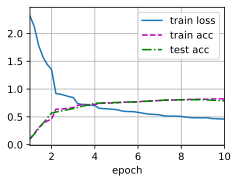

In [41]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

### 练习

1. 将平均汇聚层替换为最大汇聚层，会发生什么？

loss 0.403, train acc 0.851, test acc 0.840
36540.5 examples/sec on cuda:0


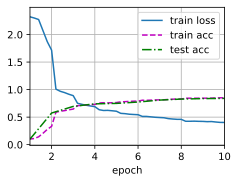

In [42]:
net = nn.Sequential(
  nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
  nn.MaxPool2d(kernel_size=2, stride=2),
  nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
  nn.MaxPool2d(kernel_size=2, stride=2),
  nn.Flatten(),
  nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
  nn.Linear(120, 84), nn.Sigmoid(),
  nn.Linear(84, 10)
)

lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

实验结果表明，准确率略有提升。

2. 尝试构建一个基于LeNet的更复杂的网络，以提高其准确性。

- 调整卷积窗口大小。

- 调整输出通道的数量。

- 调整激活函数（如ReLU）。

- 调整卷积层的数量。

- 调整全连接层的数量。

- 调整学习率和其他训练细节（例如，初始化和轮数）。

loss 0.313, train acc 0.884, test acc 0.879
38844.6 examples/sec on cuda:0


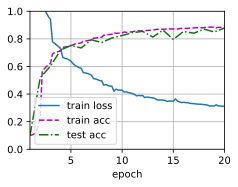

In [53]:
net = nn.Sequential(
  nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
  nn.MaxPool2d(kernel_size=2, stride=2),
  nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
  nn.MaxPool2d(kernel_size=2, stride=2),
  nn.Flatten(),
  nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
  nn.Linear(120, 84), nn.Sigmoid(),
  nn.Linear(84, 10)
)

# 加了一个全连接层效果不好，于是增加了epoch，减少了学习率
lr, num_epochs = 0.8, 20
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.232, train acc 0.914, test acc 0.889
37352.5 examples/sec on cuda:0


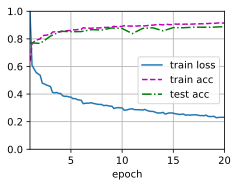

In [8]:
# 一开始把激活函数换成Relu之后模型一直不收敛，后经查阅是relu函数需要一个比较小的学习率才能收敛，因此减小学习率再次尝试

net = nn.Sequential(
  nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
  nn.MaxPool2d(kernel_size=2, stride=2),
  nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
  nn.MaxPool2d(kernel_size=2, stride=2),
  nn.Flatten(),
  nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
  nn.Linear(120, 84), nn.ReLU(),
  nn.Linear(84, 10)
)

# 学习率改为了0.1
lr, num_epochs = 0.1, 20
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

# 明显过拟合了，但是test acc和上次相比还是有提升。

3. 在MNIST数据集上尝试以上改进的网络。

In [11]:
import torchvision
from torch.utils import data

# 使用Mnist数据集
trans = torchvision.transforms.ToTensor()
mnist_train = torchvision.datasets.MNIST(
    root="data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.MNIST(
    root="data", train=False, transform=trans, download=True)
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                             num_workers=d2l.get_dataloader_workers())
test_iter = data.DataLoader(mnist_test, batch_size, shuffle=True,
                            num_workers=d2l.get_dataloader_workers())

loss 0.014, train acc 0.996, test acc 0.990
38795.7 examples/sec on cuda:0


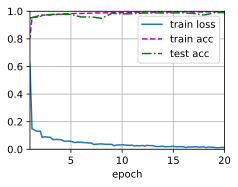

In [12]:
# 一开始把激活函数换成Relu之后模型一直不收敛，后经查阅是relu函数需要一个比较小的学习率才能收敛，因此减小学习率再次尝试

net = nn.Sequential(
  nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
  nn.MaxPool2d(kernel_size=2, stride=2),
  nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
  nn.MaxPool2d(kernel_size=2, stride=2),
  nn.Flatten(),
  nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
  nn.Linear(120, 84), nn.ReLU(),
  nn.Linear(84, 10)
)

lr, num_epochs = 0.1, 20
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

4. 显示不同输入（例如毛衣和外套）时，LeNet第一层和第二层的激活值。

In [14]:
def train_ch6_q4(net, train_iter, test_iter, num_epochs, lr, device):
  
  def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
      nn.init.xavier_uniform_(m.weight)
  net.apply(init_weights)

  print('training on', device)
  net.to(device)
  
  optimizer = torch.optim.SGD(net.parameters(), lr=lr)
  
  for epoch in range(num_epochs):
    net.train()
    for i, (X, y) in enumerate(train_iter):
      optimizer.zero_grad()
      X, y = X.to(device), y.to(device)

      x_first_Sigmoid_layer = net[0:2](X)[0:9, 1, :, :]
      d2l.show_images(x_first_Sigmoid_layer.reshape(9, 28, 28).cpu().detach(), 1, 9)
      x_second_Sigmoid_layer = net[0:5](X)[0:9, 1, :, :]
      d2l.show_images(x_second_Sigmoid_layer.reshape(9, 10, 10).cpu().detach(), 1, 9)
      # d2l.plt.show()

      break
    break


training on cuda:0


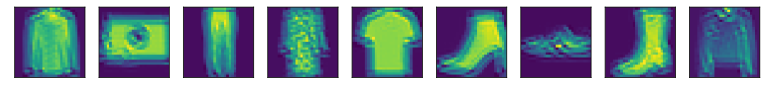

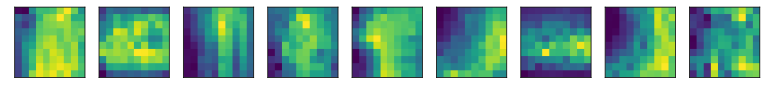

In [16]:
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

lr, num_epochs = 0.1, 20
train_ch6_q4(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())